In [1]:
import scipy as sp
import numpy as np
import seaborn as sns
from generate_data import gaussian_copula

NUM_SAMPLES = 10000

P = np.array([[ 1.0, 0.3,  0.2],
              [0.3,  1.0,  -0.7],
              [ 0.2,  -0.7,  1.0]])

P = np.array([[ 1.0, 0.7],
              [0.7,  1.0]])

def gaussian_copula(n, P):

    '''
    n: Number of samples
    p: target correlation matrix
    seed: Random seed

    The marginals distributions are also gaussian.
    '''
    d = P.shape[1] # num variables
    # Independent Normal distributions
    #Z_x = sp.stats.norm.rvs(loc=0, scale=1, size=n, random_state=seed) # N(0,1)
    #Z_y = sp.stats.norm.rvs(loc=0, scale=1, size=n, random_state=seed*2) # N(0,1)
    #Z = np.matrix([Z_x, Z_y, Z_z])
    Z = np.random.normal(loc=0, scale=1, size=d*n).reshape(n,d)

    # Cholesky Decomposition
    cholesky = np.linalg.cholesky(P)

    # Apply Cholesky to add targeted correlation and apply CDF to generate 
    Z_corr = np.dot(Z,cholesky)
    U = sp.stats.norm.cdf(Z_corr)
    G = sp.stats.norm.ppf(U)

    return cholesky,Z,U,G


In [2]:
cholesky,Z, U,G= gaussian_copula(NUM_SAMPLES,P)
print(cholesky.shape)
print(G.shape)

(2, 2)
(10000, 2)


In [3]:
np.dot(cholesky, np.transpose(cholesky))

array([[1. , 0.7],
       [0.7, 1. ]])

In [4]:
np.corrcoef(G,rowvar=False)

array([[1.        , 0.57103066],
       [0.57103066, 1.        ]])

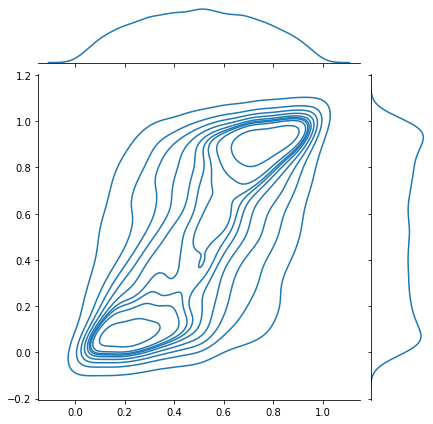

In [5]:
sns.jointplot(x=U[:,1], y=U[:,0], kind="kde");

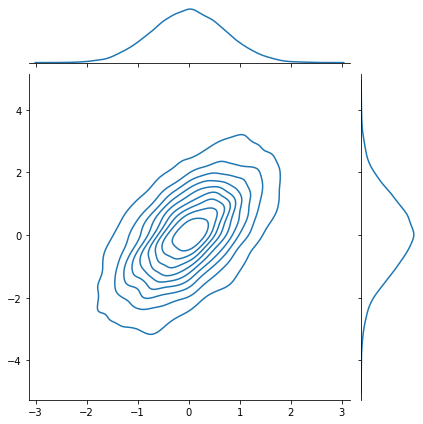

In [6]:
sns.jointplot(x=G[:,1], y=G[:,0], kind="kde");

## QCBM

In [7]:
def convert_data_to_binary_string(U,m):
    
    """ m: number of bits to digitize pseudo-samples in copula space
        U: Pseudo-sample space matrix
    """
    # Discretizing the variables bounded between 0 and 1 into 2^m levels, and assign binary string for each bin
    bins = np.linspace(0, 1, num=2**m)
    inds = np.digitize(U, bins)
    bit_data = []
    for ind in inds:
        # Contenate all variables into single bit string
        bit_sample = ""
        for ind_v in ind:
            bit_sample_var = '{:0{size}b}'.format(ind_v, size=m)
            bit_sample += bit_sample_var
            
        bit_data.append(bit_sample)
            
    return bit_data

In [8]:
binary_samples = convert_data_to_binary_string(U,NUM_QUBITS_VAR)
target_probs = empirical_distribution(binary_samples, NUM_QUBITS_VAR*NUM_VARS)

NameError: name 'NUM_QUBITS_VAR' is not defined

In [ ]:
NUM_QUBITS_VAR = 4
NUM_VARS = 2
NUM_LAYERS = 1
NUM_SHOTS = 2048


binary_samples = convert_data_to_binary_string(U,NUM_QUBITS_VAR)
target_probs = empirical_distribution(binary_samples, NUM_QUBITS_VAR*NUM_VARS)

In [ ]:
import numpy as np
from collections import Counter
from itertools import product
from qiskit import *
from qiskit.algorithms.optimizers import SPSA

def GHZstate():
    qr = QuantumRegister(NUM_QUBITS_VAR*NUM_VARS)
    qc = QuantumCircuit(qr,name='GHZstate')
    
    for i in range(NUM_QUBITS_VAR):
        qc.h(i)
        for j in range(1,NUM_VARS):
            qc.cx(i,i+j*NUM_QUBITS_VAR)
            
    return qc.to_instruction()

def parametrized_unitary(thetas,phis):
    
    """U_i transformation"""
    qr = QuantumRegister(NUM_QUBITS_VAR)
    qc = QuantumCircuit(qr,name = 'U_i')
    for i in range(NUM_QUBITS_VAR):
        qc.rz(thetas[i],i)
        qc.rx(phis[i],i)
    for i in range(NUM_QUBITS_VAR-1):
        qc.rzz(thetas[i],i,i+1)
        
    return qc.to_instruction()



def construct_copula_ansatz(params):
    
    qr = QuantumRegister(NUM_QUBITS_VAR*NUM_VARS,'q')
    qc = QuantumCircuit(qr)
    qc.append(GHZstate(),qr[:])
    for l in range(NUM_LAYERS):
        thetas = params[0,:,l] # For RZ, RZZ gates
        phis = params[1,:,l]   # For RX gates
        for k in range(0,NUM_VARS*NUM_QUBITS_VAR,NUM_QUBITS_VAR):
            qc.append(parametrized_unitary(thetas[k:k+NUM_QUBITS_VAR],phis[k:k+NUM_QUBITS_VAR]),qr[k:k+NUM_QUBITS_VAR])
    #qc.measure(qr_index, cr_index[::-1])
    qc.measure_all()

    return qc


def sample(params, num_shots = 2048):
    """
     This function performs a simulation with T shots and Q qbits. It's the parametrizable
     copula anstaz for learning a multivariate joint distribution in the copula space.
    Args:
        params: 3D array of form (2,NUM_QUBITS*NUM_VARS,NUM_LAYERS) 
                needed for the circuit.
        T: Integer number of shots that are going to take place in the simulation.
    Returns:
        born_probs: The born probabilities of the quantum state representing the model distribution.
    """
    circuit = copula_ansatz(params)
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend=simulator, shots=num_shots).result()
    counts = result.get_counts()
    born_probs = get_born_probabilities(counts,num_shots)
    return born_probs

def get_born_probabilities(counts,num_shots):
    
    binary_states = [x for x in map(''.join, product('01', repeat=NUM_QUBITS_VAR*NUM_VARS))]
    born_probs = np.zeros(2**(NUM_QUBITS_VAR*NUM_VARS))
    # if key is present, use relative freq of that particular binary state
    count_keys = sorted(counts.keys())
    for i in range(len(born_probs)):
        k = binary_states[i]
        if k in count_keys:
            born_probs[i] = counts.get(k) / num_shots 
    #plot_histogram(counts)
    return np.asarray(born_probs)

 
def cost_function(params):
    
    params = params.reshape(2, NUM_QUBITS_VAR*NUM_VARS, NUM_LAYERS)
    born_probs = sample(params,num_shots = NUM_SHOTS)
    loss = KL(born_probs,target_probs)
    return loss


In [ ]:
params = np.random.rand(2, NUM_QUBITS_VAR*NUM_VARS, NUM_LAYERS)
loss = cost_function(params)
print(loss)
#print(counts)
#plot_histogram(counts)
#qc = copula_ansatz(params)#.decompose()
#qc.draw('mpl')

In [ ]:
def KL(P,Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    epsilon = 1e-7
    # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon
    divergence = np.sum(P*np.log(P/Q))
    return divergence


def empirical_distribution(binary_samples, N_qubits):
    ''' This method outputs the empirical probability distribution given samples in a list of binary strings
    as a dictionary, with keys as outcomes, and values as probabilities-. It is used as the target distribution
    training the QCBM circuit '''
    
    counts = Counter(binary_samples)
    for element in counts:
        '''Convert occurences to relative frequencies of binary string'''
        counts[element] = counts[element]/(len(binary_samples))
    # Make sure all binary strings are represented over the space of probabilities
    for index in range(0, 2**N_qubits):
        '''If a binary string has not been seen in samples, set its value to zero'''
        if '{:0{size}b}'.format(index, size=N_qubits)  not in counts:
            counts['{:0{size}b}'.format(index, size=N_qubits)] = 0

    sorted_binary_samples_dict = {}
    keylist = sorted(counts)
    for key in keylist:
        sorted_binary_samples_dict[key] = counts[key]

    return np.asarray(list(sorted_binary_samples_dict.values()))

# Hybrid loop of optimisation 

In [ ]:
initial_params = np.random.rand(2, NUM_QUBITS_VAR*NUM_VARS, NUM_LAYERS).flatten()

class SPSACallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]
        
spsa_cbk = SPSACallback()
spsa = SPSA(maxiter=100,callback=spsa_cbk.callback,learning_rate = 0.05,perturbation=0.05)
result = spsa.minimize(cost_function, initial_params)

In [ ]:
spsa_cbk = SPSACallback()
spsa = SPSA(maxiter=300,callback=spsa_cbk.callback,learning_rate = 0.05,perturbation=0.05)
result = spsa.minimize(cost_function, initial_params)

In [ ]:
print(result)

In [ ]:
import matplotlib.pyplot as plt
plot_data = spsa_cbk.get_callback_data()  # callback data

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("KL divergence")
fig.tight_layout()

In [ ]:
# Evaluate trained probability distribution by comapring histograms 
plt.rcParams["figure.figsize"] = (30,15)
bounds = [0,1]
num_qubits = NUM_QUBITS_VAR*NUM_VARS

x = [
    bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)
]

opt_params = result.x
y = sample(opt_params.reshape(2,num_qubits,NUM_LAYERS), num_shots = 2048)
print(len(y))
# Plot distributions
plt.bar(x, y, width=0.005, label="trained distribution", color="royalblue")
plt.xticks(x, size=15, rotation=45)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Pseudo-sample space", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.bar(x,target_probs,width=0.005,
    color="deepskyblue",
    label="target distribution"
)
plt.legend(loc="best")
plt.show()